In [130]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import xml.etree.ElementTree as ET
import random
import cv2


# Paths
original_img_dir = './data/all_data/'
annotated_img_dir = './data/new_label_imgs/'
non_watermark_dir = './data/non_watermark/'
r123_watermark_dir = './data/r123_watermark/'


class WatermarkDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image=np.array(image))['image']

        return image, label

class WatermarkDetectionDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        xml_file = os.path.join(annotated_img_dir, os.path.splitext(os.path.basename(img_path))[0] + '.xml')
        _, boxes, labels = parse_xml(xml_file)

        # Process boxes and labels
        processed_boxes = []
        processed_labels = []
        for box in boxes:
            label, coords = box
            if isinstance(coords, tuple) and len(coords) == 4:
                processed_boxes.append(list(coords))
                processed_labels.append(1 if label == 'r123' else 0)  # Assuming 'r123' is the watermark class

        # If no valid boxes, create a dummy box
        if len(processed_boxes) == 0:
            processed_boxes = [[0, 0, 1, 1]]
            processed_labels = [0]  # 0 for background class

        if self.transform:
            transformed = self.transform(image=np.array(img), bboxes=processed_boxes, labels=processed_labels)
            img = transformed['image']
            processed_boxes = transformed['bboxes']

        # Convert to tensor
        boxes = torch.as_tensor(processed_boxes, dtype=torch.float32)
        labels = torch.as_tensor(processed_labels, dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return img, target

def calculate_class_weights(labels):
    class_counts = np.bincount(labels)
    total_samples = len(labels)
    class_weights = total_samples / (len(class_counts) * class_counts)
    return torch.FloatTensor(class_weights)

def split_data(image_paths, labels, test_size=0.2, random_state=42):
    return train_test_split(image_paths, labels, test_size=test_size, random_state=random_state, stratify=labels)

def include_list(_arr, include):
    temp = []
    for i in _arr:
        for _include in include:
            if i.endswith(_include):
                temp.append(i)
            else:
                continue
    return temp


def check_gpu():
    print("PyTorch version:", torch.__version__)

    if torch.cuda.is_available():
        print("CUDA is available!")
        print("CUDA version:", torch.version.cuda)

        # Get the current device
        current_device = torch.cuda.current_device()
        print("Current CUDA device:", current_device)

        # Get the name of the current device
        print("Device name:", torch.cuda.get_device_name(current_device))

        # Memory information
        print("Total memory:", torch.cuda.get_device_properties(current_device).total_memory / 1e9, "GB")
        print("Allocated memory:", torch.cuda.memory_allocated(current_device) / 1e9, "GB")
        print("Cached memory:", torch.cuda.memory_reserved(current_device) / 1e9, "GB")

        # Compute capability
        print("Compute capability:", torch.cuda.get_device_capability(current_device))
    else:
        print("CUDA is not available. You are using CPU.")
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    filename = root.find('filename').text

    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    objects = root.findall('object')
    bboxes = []
    for obj in objects:
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bboxes.append((name, (xmin, ymin, xmax, ymax)))

    return filename, bboxes, (width, height)
def visualize_image_with_bboxes(original_img_path, xml_path):
    filename, bboxes, (width, height) = parse_xml(xml_path)

    # Load the image
    img = Image.open(original_img_path)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(10, 10))

    # Display the image
    ax.imshow(img)

    # Color map for different types of watermarks
    color_map = {'r123': 'r', 'non_r123': 'b'}

    # Create Rectangle patches for each bbox
    for name, (xmin, ymin, xmax, ymax) in bboxes:
        color = color_map.get(name, 'g')  # Default to green if name not in color_map
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add label
        ax.text(xmin, ymin - 5, name, color=color, fontsize=10,
                bbox=dict(facecolor='white', edgecolor=color, alpha=0.8))

    plt.title(f"{filename} - {len(bboxes)} watermark(s)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
def plot_sample_images(directory, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 4))
    for i in range(num_samples):
        img_name = np.random.choice(os.listdir(directory))
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Size: {img.shape[1]}x{img.shape[0]}")
    plt.tight_layout()
    # return fig
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])


def get_classification_train_transform():
    return A.Compose([
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),
        A.Flip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.GaussNoise(p=0.2),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_classification_valid_transform():
    return A.Compose([
        A.Resize(height=224, width=224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_detection_train_transform():
    return A.Compose([
        A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0)),
        A.Flip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.GaussNoise(p=0.2),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_detection_valid_transform():
    return A.Compose([
        A.Resize(height=224, width=224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))



def visualize_augmentation(image, bboxes, augmented_image, augmented_bboxes):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    ax1.imshow(image)
    ax1.set_title('Original Image')
    for bbox in bboxes:
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                             linewidth=1, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)

    # Augmented image
    ax2.imshow(augmented_image.permute(1, 2, 0))  # Convert from CxHxW to HxWxC
    ax2.set_title('Augmented Image')
    for bbox in augmented_bboxes:
        rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                             linewidth=1, edgecolor='r', facecolor='none')
        ax2.add_patch(rect)

    plt.show()

# Example usage
xml_filename = random.choice(os.listdir(annotated_img_dir))   # Replace with your chosen XML filename
xml_path = os.path.join(annotated_img_dir, xml_filename)

check_gpu()

PyTorch version: 2.4.1+cu121
CUDA is available!
CUDA version: 12.1
Current CUDA device: 0
Device name: Tesla T4
Total memory: 15.835660288 GB
Allocated memory: 0.898096128 GB
Cached memory: 6.6060288 GB
Compute capability: (7, 5)


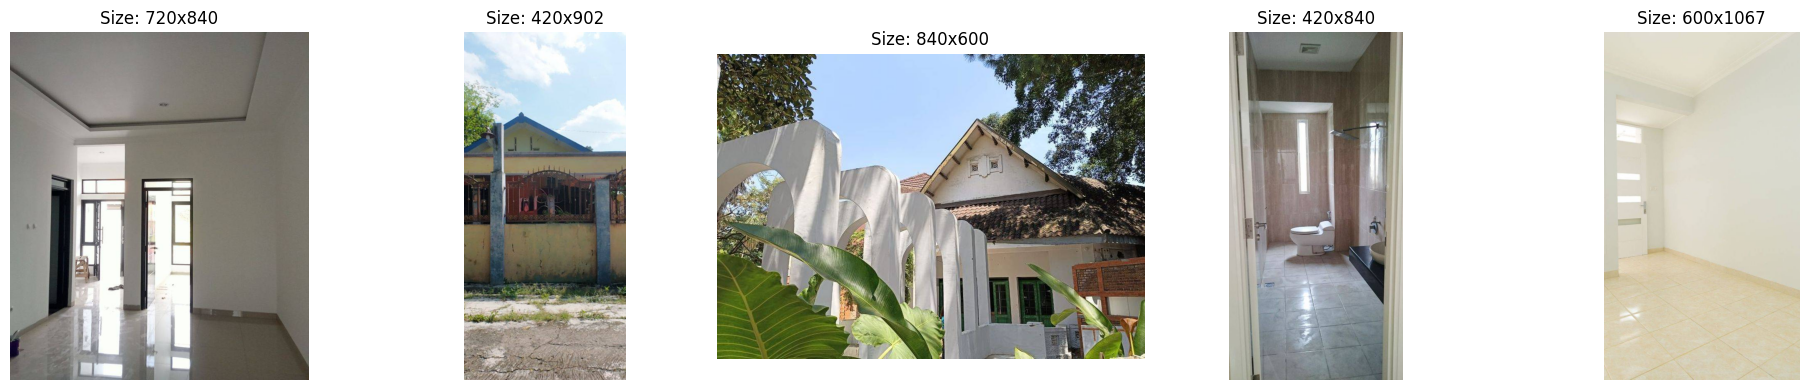

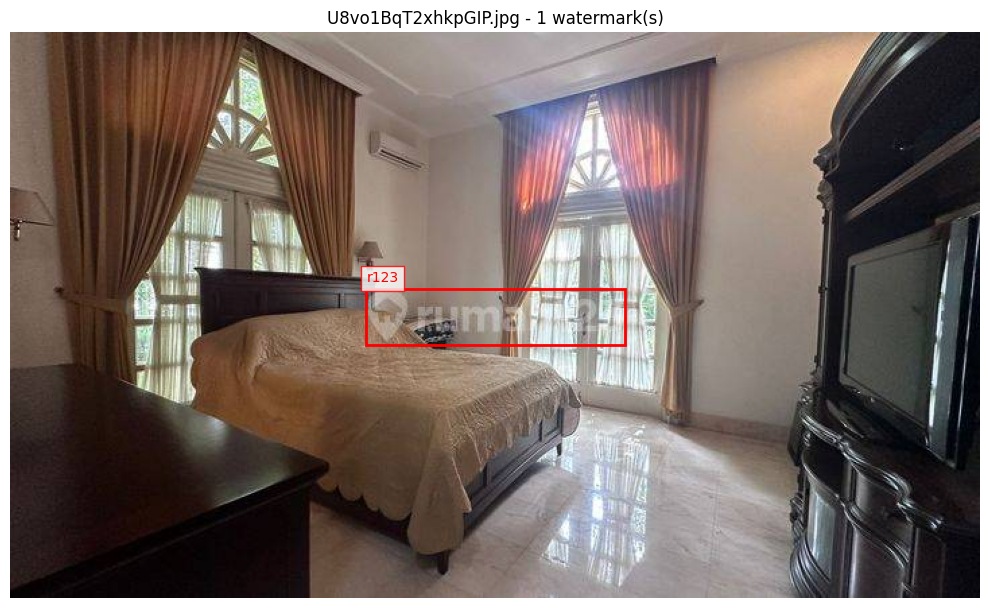

In [4]:
plot_sample_images(original_img_dir)

if os.path.exists(xml_path):
    filename, _, _ = parse_xml(xml_path)
    original_img_path = os.path.join(original_img_dir, filename)

    if os.path.exists(original_img_path):
        visualize_image_with_bboxes(original_img_path, xml_path)
    else:
        print(f"Original image not found: {original_img_path}")
else:
    print(f"XML file not found: {xml_path}")
    print("This image might not have a watermark.")

Classification Task - Non-R123 Watermark: 99, R123 Watermark: 42


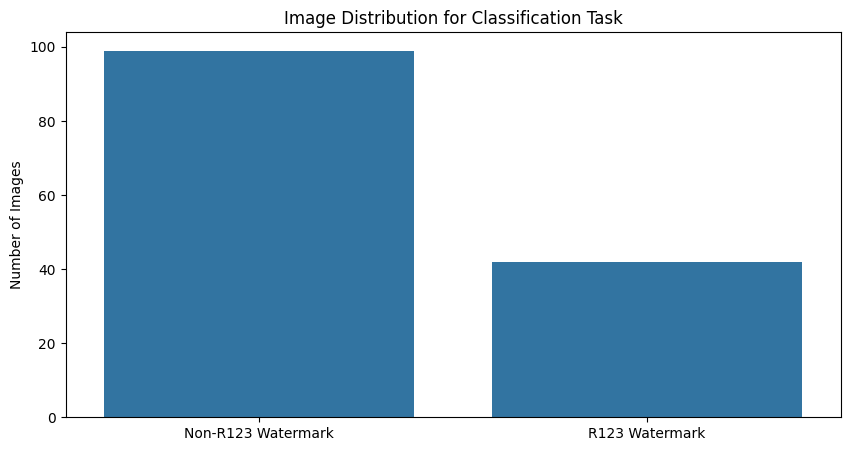

In [79]:
# Image Classification
non_watermark_count = count_images(non_watermark_dir)
r123_watermark_count = count_images(r123_watermark_dir)

plt.figure(figsize=(10, 5))
sns.barplot(x=['Non-R123 Watermark', 'R123 Watermark'], y=[non_watermark_count, r123_watermark_count])
plt.title('Image Distribution for Classification Task')
plt.ylabel('Number of Images')

print(f"Classification Task - Non-R123 Watermark: {non_watermark_count}, R123 Watermark: {r123_watermark_count}")

<ipython-input-78-b7b4ce5022fd>:223: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),


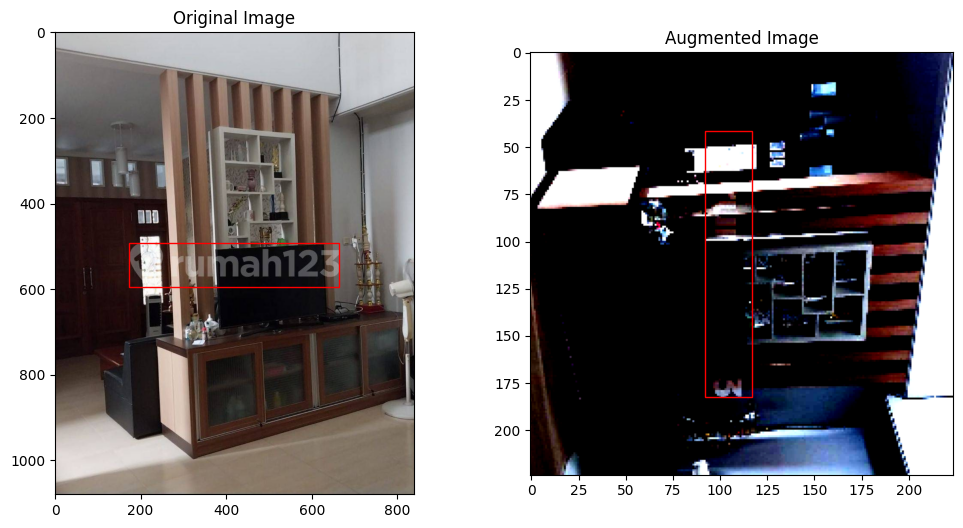

In [80]:
__SAMPLE = random.choice(os.listdir(annotated_img_dir))

image = Image.open(os.path.join(r123_watermark_dir,  __SAMPLE.split('.')[0]+ '.jpg')).convert('RGB')
bboxes = [list(parse_xml(annotated_img_dir + __SAMPLE)[1][0][1])]  # Example bounding box, replace with actual data

transform = get_detection_train_transform()
transformed = transform(image=np.array(image), bboxes=bboxes, labels=['watermark']*len(bboxes))

augmented_image = transformed['image']
augmented_bboxes = transformed['bboxes']

visualize_augmentation(np.array(image), bboxes, augmented_image, augmented_bboxes)

In [81]:
# For image classification
all_image_paths = [os.path.join(original_img_dir, f) for f in os.listdir(non_watermark_dir)] + \
                  [os.path.join(original_img_dir, f) for f in os.listdir(r123_watermark_dir)]
all_labels = [0] * len(os.listdir(non_watermark_dir)) + [1] * len(os.listdir(r123_watermark_dir))

train_paths, test_paths, train_labels, test_labels = split_data(all_image_paths, all_labels)

print(f"Classification - Training samples: {len(train_paths)}, Testing samples: {len(test_paths)}")

Classification - Training samples: 112, Testing samples: 29


In [82]:
# For object detection
OD__DATA = [i.split('.')[0] for i in include_list(os.listdir(annotated_img_dir), ['.xml'])]

file_dict = {file: os.path.join(original_img_dir, file) for file in os.listdir(original_img_dir)}
watermark_images = [file_dict[j] for i in OD__DATA for j in file_dict if j.startswith(i)]

train_od_paths, test_od_paths = train_test_split(watermark_images, test_size=0.2, random_state=42)

print(f"Object Detection - Training samples: {len(train_od_paths)}, Testing samples: {len(test_od_paths)}")

Object Detection - Training samples: 48, Testing samples: 12


In [83]:
class_weights = calculate_class_weights(train_labels)
print("Class weights:", class_weights)

# Create weighted sampler for classification training data
sample_weights = [class_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_dataset = WatermarkDataset(train_paths, train_labels, transform=get_classification_train_transform())
test_dataset = WatermarkDataset(test_paths, test_labels, transform=get_classification_valid_transform())

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Create datasets and dataloaders for object detection
train_od_dataset = WatermarkDetectionDataset(train_od_paths, transform=get_detection_train_transform())
test_od_dataset = WatermarkDetectionDataset(test_od_paths, transform=get_detection_valid_transform())

train_od_loader = DataLoader(train_od_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_od_loader = DataLoader(test_od_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

Class weights: tensor([0.7089, 1.6970])


<ipython-input-78-b7b4ce5022fd>:206: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),
<ipython-input-78-b7b4ce5022fd>:223: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),


Inspecting training data:
Sample 0:
Image shape: torch.Size([3, 224, 224])
Number of boxes: 1
Boxes: tensor([[ 73.3600, 101.5467, 149.8000, 122.4533]])
Labels: tensor([1])




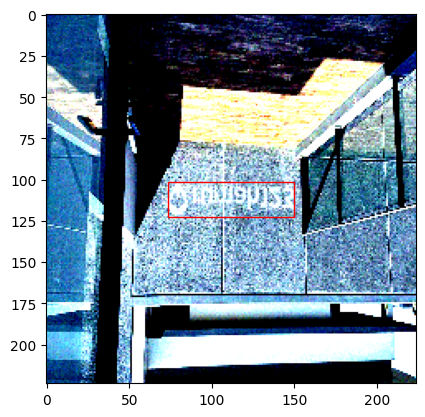

Sample 1:
Image shape: torch.Size([3, 224, 224])
Number of boxes: 1
Boxes: tensor([[ 80.5393, 101.1613, 158.5618, 121.9355]])
Labels: tensor([1])




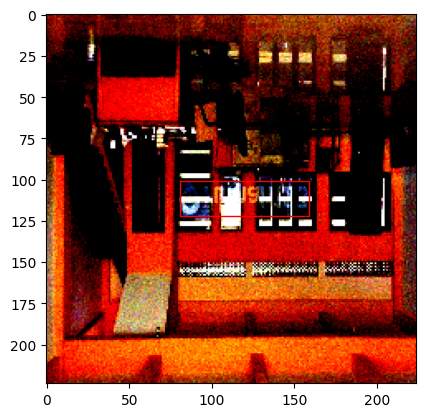

Sample 2:
Image shape: torch.Size([3, 224, 224])
Number of boxes: 2
Boxes: tensor([[ 76.9067, 102.5684, 146.7200, 114.3579],
        [ 43.3067,  97.5579, 179.5733, 119.0737]])
Labels: tensor([0, 1])




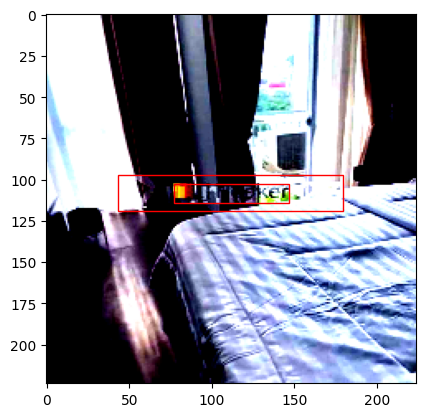

Sample 3:
Image shape: torch.Size([3, 224, 224])
Number of boxes: 1
Boxes: tensor([[ 99.9600,  31.3600, 124.0400, 194.1333]])
Labels: tensor([1])




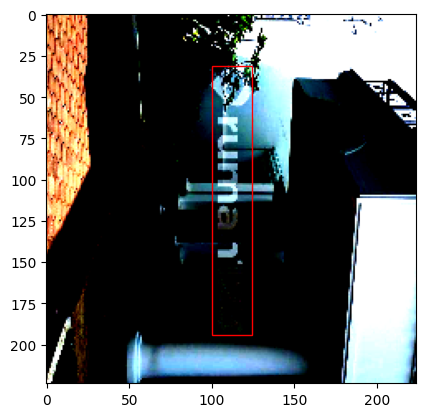

Sample 4:
Image shape: torch.Size([3, 224, 224])
Number of boxes: 1
Boxes: tensor([[ 96.1333,  11.2000, 127.8667, 213.6296]])
Labels: tensor([1])




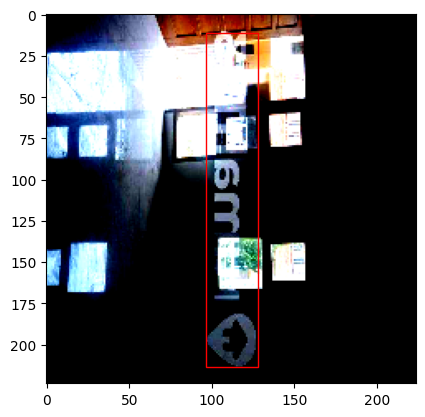

Inspecting testing data:
Sample 0:
Image shape: torch.Size([3, 224, 224])
Number of boxes: 1
Boxes: tensor([[ 46.4000, 100.8000, 176.5333, 122.7852]])
Labels: tensor([1])




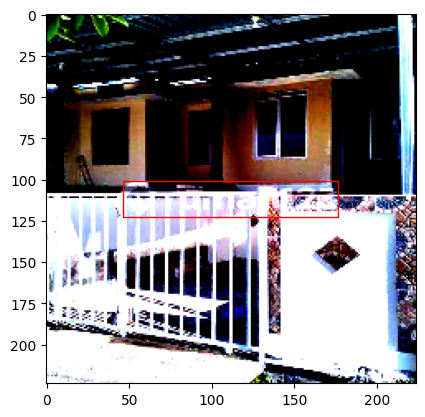

Sample 1:
Image shape: torch.Size([3, 224, 224])
Number of boxes: 1
Boxes: tensor([[ 69.3778, 102.2933, 154.6222, 122.8267]])
Labels: tensor([1])




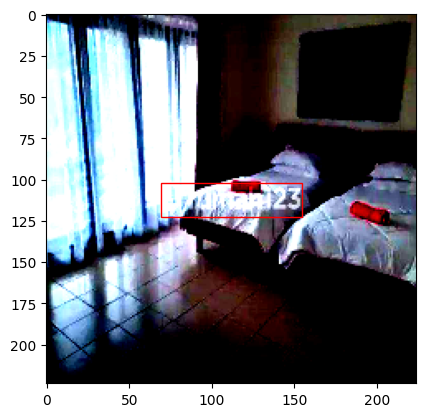

Sample 2:
Image shape: torch.Size([3, 224, 224])
Number of boxes: 1
Boxes: tensor([[ 69.6889, 101.5467, 154.0000, 122.8267]])
Labels: tensor([1])




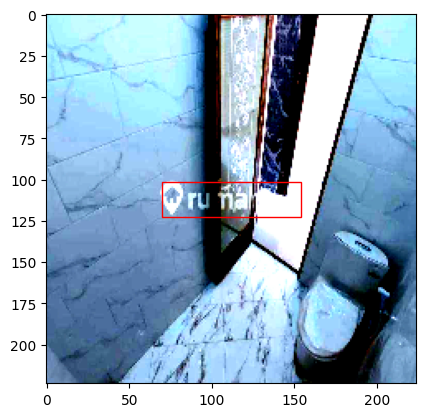

Sample 3:
Image shape: torch.Size([3, 224, 224])
Number of boxes: 1
Boxes: tensor([[ 68.5333, 102.0444, 155.4667, 122.8889]])
Labels: tensor([1])




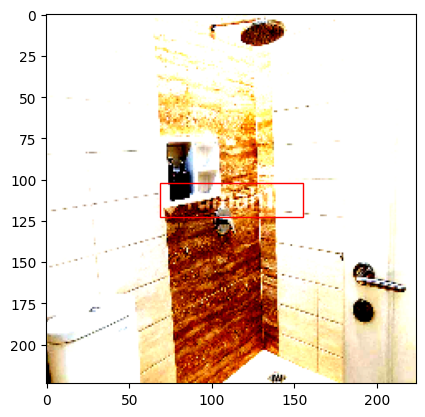

Sample 4:
Image shape: torch.Size([3, 224, 224])
Number of boxes: 1
Boxes: tensor([[ 73.4222, 101.6296, 149.9556, 122.7852]])
Labels: tensor([1])




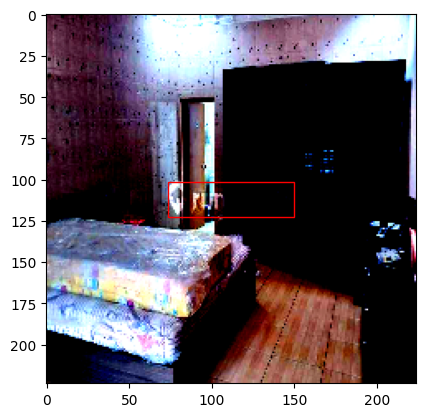

Checking first batch from DataLoader:
Batch size: 4
Image shape: torch.Size([3, 224, 224])
Target keys: dict_keys(['boxes', 'labels'])
Number of boxes in first image: 1


In [84]:
def inspect_object_detection_data(dataset, num_samples=5):
    for i in range(min(num_samples, len(dataset))):
        img, target = dataset[i]

        print(f"Sample {i}:")
        print(f"Image shape: {img.shape}")
        print(f"Number of boxes: {len(target['boxes'])}")
        print(f"Boxes: {target['boxes']}")
        print(f"Labels: {target['labels']}")
        print("\n")

        # Visualize the image with bounding boxes
        fig, ax = plt.subplots(1)
        img_np = img.permute(1, 2, 0).cpu().numpy()  # Convert from CxHxW to HxWxC
        ax.imshow(img_np)

        for box in target['boxes']:
            x, y, w, h = box.tolist()
            rect = patches.Rectangle((x, y), w-x, h-y, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        plt.show()

# Usage
print("Inspecting training data:")
inspect_object_detection_data(train_od_dataset)

print("Inspecting testing data:")
inspect_object_detection_data(test_od_dataset)

# Check the first batch from the DataLoader
print("Checking first batch from DataLoader:")
images, targets = next(iter(train_od_loader))
print(f"Batch size: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Target keys: {targets[0].keys()}")
print(f"Number of boxes in first image: {len(targets[0]['boxes'])}")

In [85]:
def save_model(model, optimizer, epoch, train_loss, train_iou, test_iou, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_iou': train_iou,
        'test_iou': test_iou
    }
    torch.save(checkpoint, filename)
    print(f"Model saved to {filename}")

def load_model(model, optimizer, filename):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        train_loss = checkpoint['train_loss']
        train_iou = checkpoint['train_iou']
        test_iou = checkpoint['test_iou']
        print(f"Model loaded from {filename}")
        return model, optimizer, epoch, train_loss, train_iou, test_iou
    else:
        print(f"No checkpoint found at {filename}")
        return model, optimizer, 0, [], [], []

In [138]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models.detection.rpn import AnchorGenerator



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Classification Model
class WatermarkClassifier(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(WatermarkClassifier, self).__init__()
        self.resnet = models.resnet101(pretrained=True)  # Use ResNet101 instead of ResNet50
        num_ftrs = self.resnet.fc.in_features

        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

        self.fc1 = nn.Linear(num_ftrs, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

classification_model = WatermarkClassifier(num_classes=2, dropout_rate=0.2).to(device)
classification_criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
classification_optimizer = torch.optim.Adam(classification_model.parameters(), lr=0.001)


# Object Detection Model
def get_object_detection_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # anchor_generator = AnchorGenerator(
    #                   sizes=((32, 64, 128, 256, 512),),
    #                   aspect_ratios=((0.5, 1.0, 2.0),)
    #                   )


    # Increase the number of proposals
    model.rpn.nms_thresh = 0.6
    model.rpn.post_nms_top_n_train = 2000
    model.rpn.post_nms_top_n_test = 1000
    # model.rpn.anchor_generator = anchor_generator
    return model

detection_model = get_object_detection_model(num_classes=2).to(device)  # Background and watermark
detection_optimizer = torch.optim.SGD(detection_model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to ge

Training Classification Model...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train - Loss: 0.6021, Accuracy: 0.5714, F1: 0.5238
Test - Loss: 58.4337, Accuracy: 0.3103, F1: 0.1470
New best model saved with F1 score: 0.1470
Epoch 2/50
Train - Loss: 0.5423, Accuracy: 0.5268, F1: 0.4627
Test - Loss: 146.6560, Accuracy: 0.3103, F1: 0.1470
Epoch 3/50
Train - Loss: 0.5383, Accuracy: 0.6518, F1: 0.6355
Test - Loss: 133.6847, Accuracy: 0.3103, F1: 0.1470
Epoch 4/50
Train - Loss: 0.4748, Accuracy: 0.7232, F1: 0.7232
Test - Loss: 24.1862, Accuracy: 0.2759, F1: 0.1342
Epoch 5/50
Train - Loss: 0.5005, Accuracy: 0.6964, F1: 0.6968
Test - Loss: 4.8526, Accuracy: 0.3793, F1: 0.2806
New best model saved with F1 score: 0.2806
Epoch 6/50
Train - Loss: 0.3980, Accuracy: 0.7500, F1: 0.7451
Test - Loss: 3.5558, Accuracy: 0.3448, F1: 0.2167
Epoch 7/50
Train - Loss: 0.4578, Accuracy: 0.7143, F1: 0.6938
Test - Loss: 0.7404, Accuracy: 0.5862, F1: 0.5803
New best model saved with F1 score: 0.5803
Epoch 8/50
Train - Loss: 0.3940, Accuracy: 0.7500, F1: 0.7397
Test - Loss: 0.8912

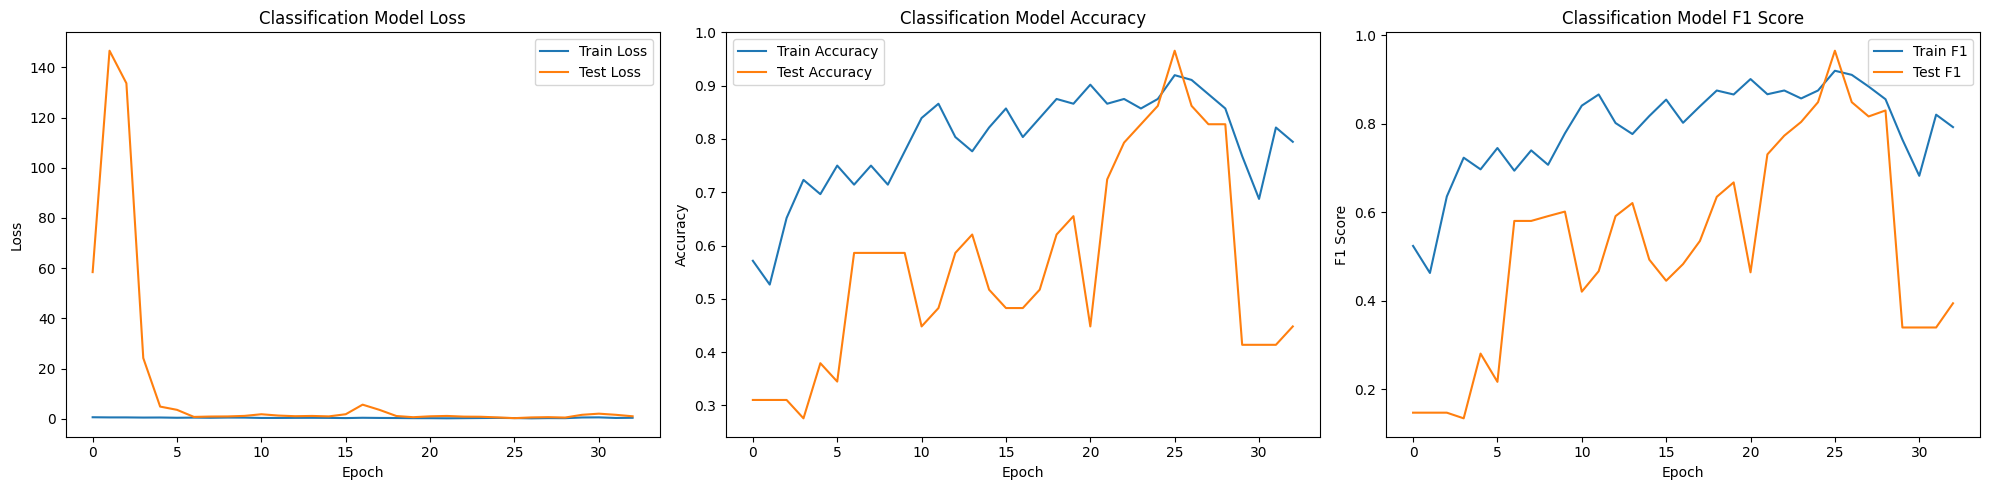

Model training completed.


In [136]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_score = None
        self.best_weights = None
        self.counter = 0
        self.stopped_epoch = 0

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_weights = model.state_dict()
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.stopped_epoch = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_weights)
                return True
        else:
            self.best_score = score
            self.best_weights = model.state_dict()
            self.counter = 0
        return False

from sklearn.metrics import precision_score, recall_score, f1_score
import os

def train_classification_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50, patience=7, save_dir='./models'):
    train_accuracies, test_accuracies = [], []
    train_losses, test_losses = [], []
    train_f1s, test_f1s = [], []
    early_stopping = EarlyStopping(patience=patience)
    best_test_f1 = 0

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    classification_scheduler = ReduceLROnPlateau(classification_optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss = 0
        train_predictions = []
        train_true_labels = []

        for inputs, labels in train_loader:
            if inputs is None or labels is None:
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            train_loss += loss.item()

            train_predictions.extend(predicted.cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

        train_accuracy = train_correct / train_total
        train_accuracies.append(train_accuracy)
        train_avg_loss = train_loss / len(train_loader)
        train_losses.append(train_avg_loss)
        train_f1 = f1_score(train_true_labels, train_predictions, average='weighted')
        train_f1s.append(train_f1)

        model.eval()
        test_correct = 0
        test_total = 0
        test_loss = 0
        test_predictions = []
        test_true_labels = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                if inputs is None or labels is None:
                    continue
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
                test_loss += loss.item()

                test_predictions.extend(predicted.cpu().numpy())
                test_true_labels.extend(labels.cpu().numpy())

        test_accuracy = test_correct / test_total
        test_accuracies.append(test_accuracy)
        test_avg_loss = test_loss / len(test_loader)
        test_losses.append(test_avg_loss)
        test_f1 = f1_score(test_true_labels, test_predictions, average='weighted')
        test_f1s.append(test_f1)
        classification_scheduler.step(test_f1)


        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train - Loss: {train_avg_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"Test - Loss: {test_avg_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}")

        # Save the best model
        if test_f1 > best_test_f1:
            best_test_f1 = test_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'test_f1': test_f1,
            }, os.path.join(save_dir, 'best_classification_model_v2.pth'))
            print(f"New best model saved with F1 score: {test_f1:.4f}")

        if early_stopping(test_f1, model):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Save the final model
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'test_f1': test_f1,
    }, os.path.join(save_dir, 'final_classification_model_v2.pth'))

    return model, train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s

# Usage
print("Training Classification Model...")
classification_model, train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s = train_classification_model(
    classification_model, train_loader, test_loader, classification_criterion, classification_optimizer,
    num_epochs=50, patience=7, save_dir='./classification_models'
)

# Plot training performance for classification
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Model Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Model Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(train_f1s, label='Train F1')
plt.plot(test_f1s, label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Classification Model F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

print("Model training completed.")

Training Object Detection Model...
Epoch 1/50, Avg Loss: 0.0790, Train IoU: 0.1944, Test IoU: 0.2281
Epoch 2/50, Avg Loss: 0.0758, Train IoU: 0.1739, Test IoU: 0.2017
Epoch 3/50, Avg Loss: 0.0730, Train IoU: 0.2862, Test IoU: 0.2819
Epoch 4/50, Avg Loss: 0.0813, Train IoU: 0.2049, Test IoU: 0.2208
Epoch 5/50, Avg Loss: 0.0809, Train IoU: 0.2045, Test IoU: 0.2310
Epoch 6/50, Avg Loss: 0.0646, Train IoU: 0.2706, Test IoU: 0.2438
Epoch 7/50, Avg Loss: 0.1000, Train IoU: 0.2387, Test IoU: 0.2165
Epoch 8/50, Avg Loss: 0.0809, Train IoU: 0.2042, Test IoU: 0.2250
Epoch 9/50, Avg Loss: 0.0742, Train IoU: 0.2829, Test IoU: 0.2918
Epoch 10/50, Avg Loss: 0.0597, Train IoU: 0.2578, Test IoU: 0.2743
Epoch 11/50, Avg Loss: 0.0611, Train IoU: 0.3318, Test IoU: 0.3333
Epoch 12/50, Avg Loss: 0.0602, Train IoU: 0.3049, Test IoU: 0.2462
Epoch 13/50, Avg Loss: 0.0539, Train IoU: 0.3528, Test IoU: 0.2765
Epoch 14/50, Avg Loss: 0.0493, Train IoU: 0.4423, Test IoU: 0.3783
Early stopping triggered at epoch 14

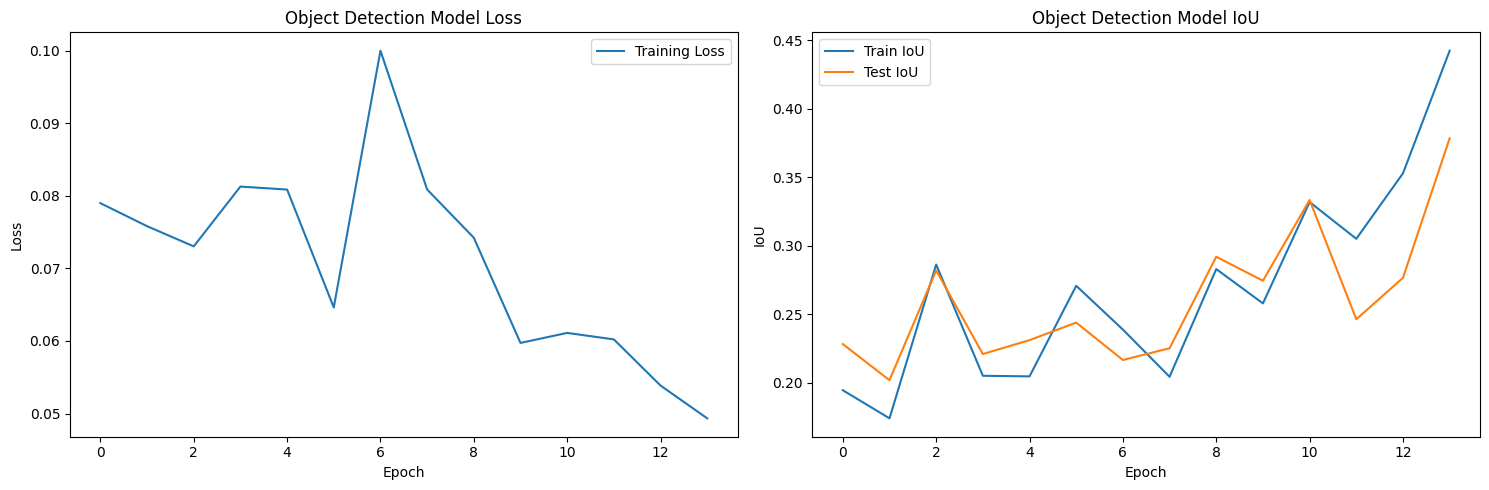

Model training completed.


In [140]:
from torchvision.ops import box_iou

def calculate_iou(pred_boxes, true_boxes):
    return box_iou(pred_boxes, true_boxes)

def evaluate_model(model, data_loader, device):
    model.eval()
    total_iou = 0
    total_samples = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for target, output in zip(targets, outputs):
                pred_boxes = output['boxes']
                true_boxes = target['boxes']
                if pred_boxes.shape[0] > 0 and true_boxes.shape[0] > 0:
                    iou = calculate_iou(pred_boxes, true_boxes)
                    total_iou += iou.max(dim=1)[0].mean().item()
                    # total_samples += true_boxes.shape[0]
                    total_samples += 1

    mean_iou = total_iou / total_samples if total_samples > 0 else 0
    return mean_iou

def train_detection_model(model, train_loader, test_loader, optimizer, num_epochs=50, patience=7, save_dir = './object_detection_models/'):
    model.to(device)
    early_stopping = EarlyStopping(patience=patience)
    train_losses = []
    train_ious = []
    test_ious = []

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        valid_batches = 0

        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Filter out images with no boxes
            valid_samples = [i for i, t in enumerate(targets) if t['boxes'].numel() > 0]
            if not valid_samples:
                continue

            images = [images[i] for i in valid_samples]
            targets = [targets[i] for i in valid_samples]

            # Ensure boxes have the correct shape (N, 4)
            for t in targets:
                if t['boxes'].numel() > 0:
                    t['boxes'] = t['boxes'].view(-1, 4)

            try:
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                total_loss += losses.item()
                valid_batches += 1
            except RuntimeError as e:
                print(f"Error in batch: {e}")
                continue

        if valid_batches > 0:
            avg_loss = total_loss / valid_batches
            train_losses.append(avg_loss)

            # Calculate IoU for train set
            train_iou = evaluate_model(model, train_loader, device)
            train_ious.append(train_iou)

            # Calculate IoU for test set
            test_iou = evaluate_model(model, test_loader, device)
            test_ious.append(test_iou)

            scheduler.step(test_iou)

            print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}, Train IoU: {train_iou:.4f}, Test IoU: {test_iou:.4f}")

            if early_stopping(avg_loss, model):
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        else:
            print(f"Epoch {epoch+1}/{num_epochs}, No valid batches")
    # Save the final model
    save_model(model, optimizer, epoch, avg_loss, train_iou, test_iou,
               os.path.join(save_dir, 'final_model_v2.pth'))

    return model, train_losses, train_ious, test_ious

# Usage
print("Training Object Detection Model...")
detection_model, train_losses, train_ious, test_ious = train_detection_model(
    detection_model, train_od_loader, test_od_loader, detection_optimizer,
    num_epochs=50, patience=7
)

# Plot training performance for object detection
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Object Detection Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_ious, label='Train IoU')
plt.plot(test_ious, label='Test IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Object Detection Model IoU')
plt.legend()

plt.tight_layout()
plt.show()

print("Model training completed.")

In [89]:
### LOAD MODEL

<ipython-input-141-3b28784103b4>:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Classification Results:


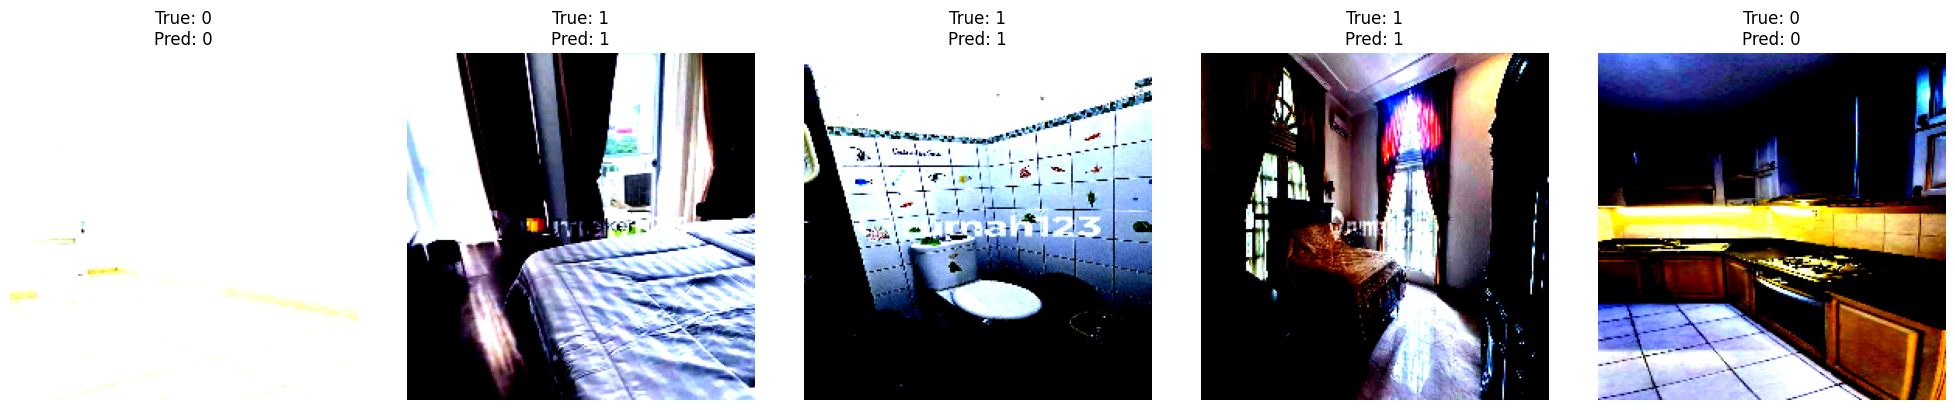

Object Detection Results:


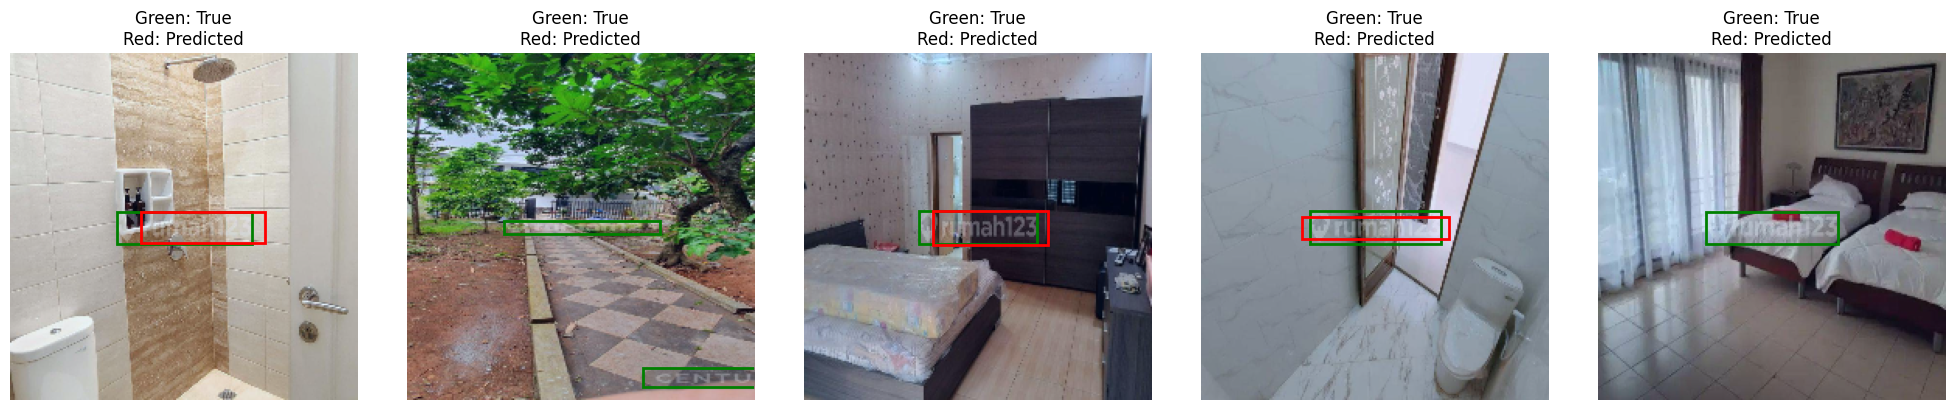

In [141]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import functional as F
from PIL import Image
import random
import numpy as np

def display_classification_results(model, test_loader, n_samples=5):
    model.eval()
    fig, axs = plt.subplots(1, n_samples, figsize=(20, 4))

    all_samples = []
    device = next(model.parameters()).device  # Get the device of the model

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)  # Move images to the same device as the model
            labels = labels.to(device)  # Move labels to the same device as the model
            batch_predictions = model(images).argmax(dim=1)
            for img, label, pred in zip(images.cpu(), labels.cpu(), batch_predictions.cpu()):
                all_samples.append((img, label.item(), pred.item()))
            if len(all_samples) >= n_samples:
                break

    selected_samples = random.sample(all_samples, n_samples)

    for i, (img, true_label, pred_label) in enumerate(selected_samples):
        axs[i].imshow(img.permute(1, 2, 0))
        axs[i].set_title(f'True: {true_label}\nPred: {pred_label}')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

def display_object_detection_results(model, test_loader, n_samples=5):
    model.eval()
    fig, axs = plt.subplots(1, n_samples, figsize=(20, 4))

    all_samples = []
    with torch.no_grad():
        for images, targets in test_loader:
            images = list(img.to(next(model.parameters()).device) for img in images)
            outputs = model(images)
            for img, target, output in zip(images, targets, outputs):
                all_samples.append((img.cpu(), target, {k: v.cpu() for k, v in output.items()}))
            if len(all_samples) >= n_samples:
                break

    selected_samples = random.sample(all_samples, n_samples)

    for i, (img, target, output) in enumerate(selected_samples):
        img_np = img.permute(1, 2, 0).numpy()

        # Normalize the image for display
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        axs[i].imshow(img_np)

        # Draw ground truth boxes
        for box in target['boxes']:
            rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                     linewidth=2, edgecolor='g', facecolor='none')
            axs[i].add_patch(rect)

        # Draw predicted boxes
        for box, score in zip(output['boxes'], output['scores']):
            if score > 0.5:  # You can adjust this threshold
                rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                         linewidth=2, edgecolor='r', facecolor='none')
                axs[i].add_patch(rect)

        axs[i].set_title(f'Green: True\nRed: Predicted')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

def load_model(model, model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    return model


# Usage example
classification_model_path = './classification_models/best_classification_model_v2.pth'
detection_model_path = './object_detection_models/final_model_v2.pth'

# Load models
classification_model = load_model(WatermarkClassifier(), classification_model_path, device)
detection_model = load_model(get_object_detection_model(num_classes=2), detection_model_path, device)

# Display results on test data
print("Classification Results:")
display_classification_results(classification_model, test_loader, n_samples=5)

print("Object Detection Results:")
display_object_detection_results(detection_model, test_od_loader, n_samples=5)

Prediction on Unseen Data:


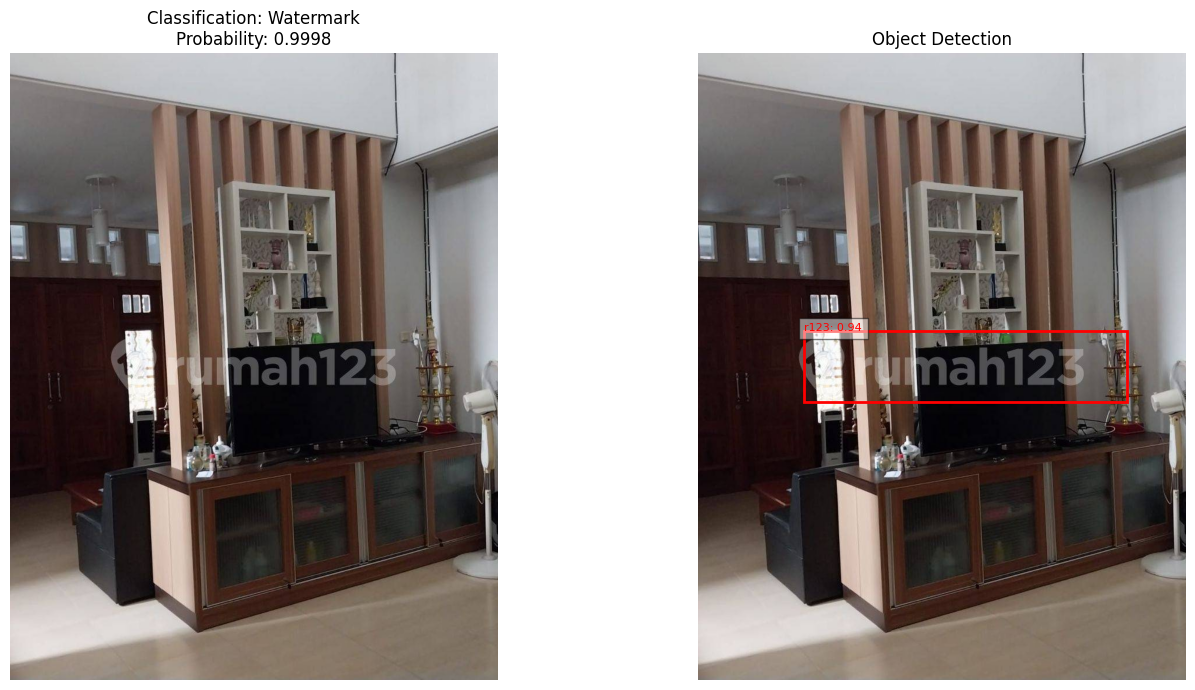

Image Classification Result:
  Watermark Probability: 0.9998
  Prediction: Watermark

Object Detection Results:
  Detected Objects: 1 (scores > 0.5)
  Top 5 detections:
    1. r123: 0.9410


In [142]:
def predict_unseen_data(classification_model, detection_model, image_path, classification_transform, detection_transform):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    original_image = np.array(image)

    # Classification
    classification_image = classification_transform(image=original_image)['image']
    classification_tensor = classification_image.unsqueeze(0).to(next(classification_model.parameters()).device)

    classification_model.eval()
    with torch.no_grad():
        classification_output = classification_model(classification_tensor)
        predicted_probs = torch.softmax(classification_output, dim=1)
        watermark_prob = predicted_probs[0][1].item()  # Assuming 1 is the watermark class

    # Object Detection
    detection_image = detection_transform(image=original_image, bboxes=[], labels=[])['image']
    detection_tensor = detection_image.unsqueeze(0).to(next(detection_model.parameters()).device)

    detection_model.eval()
    with torch.no_grad():
        detection_output = detection_model(detection_tensor)[0]

    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

    # Original image with classification result
    ax1.imshow(original_image)
    ax1.set_title(f'Classification: {"Watermark" if watermark_prob > 0.5 else "No Watermark"}\nProbability: {watermark_prob:.4f}')
    ax1.axis('off')

    # Image with bounding boxes
    ax2.imshow(original_image)
    height, width = original_image.shape[:2]
    for box, score, label in zip(detection_output['boxes'].cpu(), detection_output['scores'].cpu(), detection_output['labels'].cpu()):
        if score > 0.3:  # Lowered threshold for visualization
            box = box.numpy()
            # Scale the box coordinates to match the original image size
            x1, y1, x2, y2 = box
            x1 = int(x1 * width / 224)
            y1 = int(y1 * height / 224)
            x2 = int(x2 * width / 224)
            y2 = int(y2 * height / 224)

            label_name = "r123" if label.item() == 1 else "non_r123"
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax2.add_patch(rect)
            ax2.text(x1, y1, f'{label_name}: {score.item():.2f}', color='red', fontsize=8,
                     bbox=dict(facecolor='white', alpha=0.5))
    ax2.set_title('Object Detection')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return watermark_prob, detection_output

# Usage
classification_transform = get_classification_valid_transform()
detection_transform = get_detection_valid_transform()

unseen_image_path = './data/all_data/IqyfMrqcScPxb9bS.jpg'

print("Prediction on Unseen Data:")
watermark_prob, detection_prediction = predict_unseen_data(classification_model, detection_model, unseen_image_path, classification_transform, detection_transform)

print(f"Image Classification Result:")
print(f"  Watermark Probability: {watermark_prob:.4f}")
print(f"  Prediction: {'Watermark' if watermark_prob > 0.5 else 'No Watermark'}")

print("\nObject Detection Results:")
r123_detections = [(score.item(), label.item()) for score, label in zip(detection_prediction['scores'], detection_prediction['labels']) if score > 0.5]
print(f"  Detected Objects: {len(r123_detections)} (scores > 0.5)")
print("  Top 5 detections:")
for i, (score, label) in enumerate(sorted(r123_detections, reverse=True)[:5], 1):
    label_name = "r123" if label == 1 else "non_r123"
    print(f"    {i}. {label_name}: {score:.4f}")

Prediction on Unseen Data:


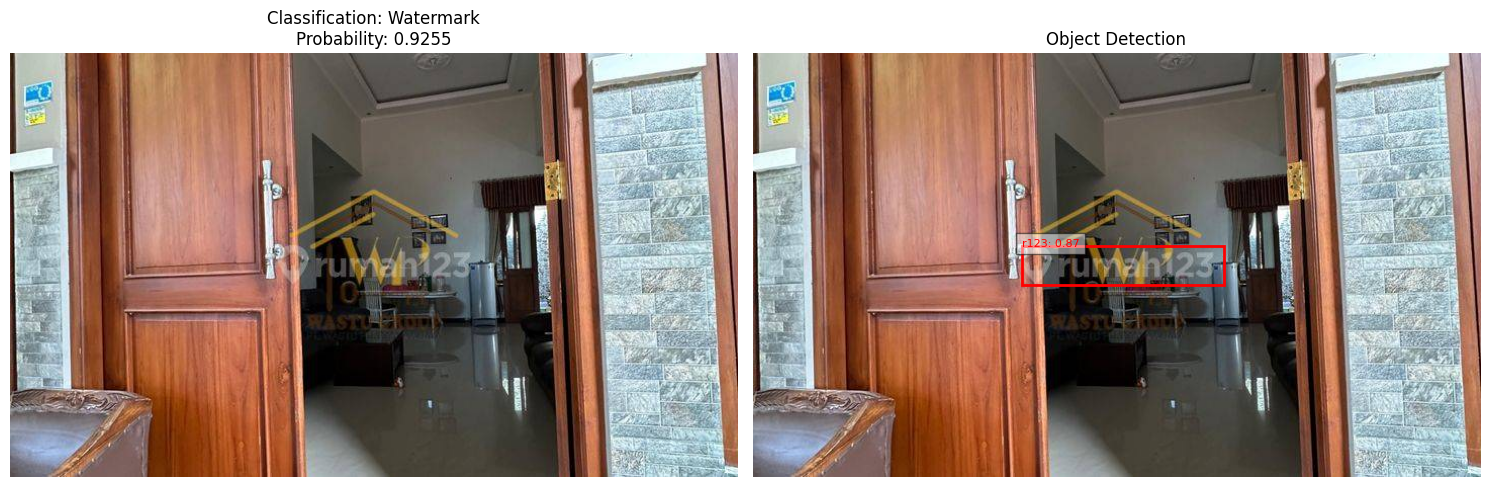

Image Classification Result:
  Watermark Probability: 0.9255
  Prediction: Watermark

Object Detection Results:
  Detected Objects: 1 (scores > 0.5)
  Top 5 detections:
    1. r123: 0.8722


In [144]:
unseen_image_path = './data/all_data/3oatBcyDa94sDBMC.jpg'

print("Prediction on Unseen Data:")
watermark_prob, detection_prediction = predict_unseen_data(classification_model, detection_model, unseen_image_path, classification_transform, detection_transform)

print(f"Image Classification Result:")
print(f"  Watermark Probability: {watermark_prob:.4f}")
print(f"  Prediction: {'Watermark' if watermark_prob > 0.5 else 'No Watermark'}")

print("\nObject Detection Results:")
r123_detections = [(score.item(), label.item()) for score, label in zip(detection_prediction['scores'], detection_prediction['labels']) if score > 0.5]
print(f"  Detected Objects: {len(r123_detections)} (scores > 0.5)")
print("  Top 5 detections:")
for i, (score, label) in enumerate(sorted(r123_detections, reverse=True)[:5], 1):
    label_name = "r123" if label == 1 else "non_r123"
    print(f"    {i}. {label_name}: {score:.4f}")